In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [5]:
IMG_SIZE=256
BATCH=32
CHANNELS=3
dataset=tf.keras.utils.image_dataset_from_directory(
"Pistachio_Image_Dataset",
shuffle=True,
image_size=(IMG_SIZE,IMG_SIZE),
batch_size=BATCH
)


Found 2148 files belonging to 2 classes.


In [6]:
dataset.class_names

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [7]:
classes=['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [8]:
len(dataset)

68

In [9]:
for image_batch,label_batch in dataset.take(2):
    # print(image_batch.numpy())
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1]
(32, 256, 256, 3)
[1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1]


In [10]:
image_batch[0].shape

TensorShape([256, 256, 3])

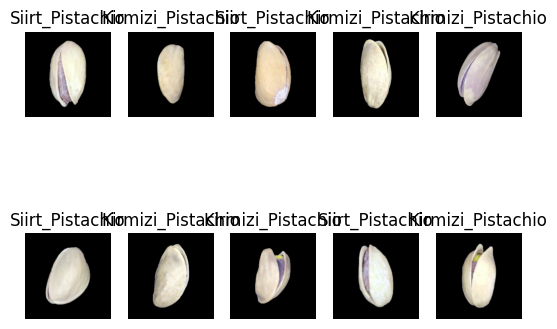

In [11]:
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(2,5,i+1)#uint8,float32 are most common 
        plt.imshow(image_batch[i].numpy().astype("uint8"))#it means each pixel in imahg is represented by 8 bit unsigned integer
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [12]:
# def partition(d,t,vl,l):
#     train=d.take(int(t*l))
#     val=d.skip(int(t*l)).take(int(vl*l))
#     test=d.skip(int(t*l)).skip(int(vl*l))
#     return train,val,test
# tds,vds,teds=partition(datasets,0.8,0.1,len(datasets))
# print(tds)

def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=100):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    

In [13]:
tds,vds,teds=get_dataset_partition(dataset)

In [14]:
len(tds),len(vds),len(teds)

(54, 6, 8)

In [15]:
'''data preprocessing part'''
tds=tds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
vds=vds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
teds=teds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [18]:
input_shape=(BATCH,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(n_classes,activation='sigmoid'),
])
model.build(input_shape=input_shape)

C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:

print(model.summary())
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 50176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 128)                   │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,330 (25.98 MB)

 Trainable params: 6,811,330 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
EPOCHS=10
model.fit(tds,epochs=EPOCHS,batch_size=BATCH, verbose=1,validation_data=vds)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5948 - loss: 0.7063 - val_accuracy: 0.8125 - val_loss: 0.4370
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8139 - loss: 0.4121 - val_accuracy: 0.7708 - val_loss: 0.4655
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8259 - loss: 0.3913 - val_accuracy: 0.7865 - val_loss: 0.4615
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8328 - loss: 0.3817 - val_accuracy: 0.8177 - val_loss: 0.4175
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8137 - loss: 0.4105 - val_accuracy: 0.8073 - val_loss: 0.4328
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8331 - loss: 0.3750 - val_accuracy: 0.7969 - val_loss: 0.4846
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8149 - loss: 0.4105 - val_accuracy: 0.7917 - val_loss: 0.4538
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8275 - loss: 0.3745 - val_accuracy: 0.8073 - val_loss

In [21]:
model.evaluate(teds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.8020 - loss: 0.3883


[0.3948317766189575, 0.8125]

enter batch number. 2


first image to predict
first image's actual label: Kirmizi_Pistachio
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
predicted label: [0.5706129 0.3829273]
predicted label: 0
first image to predict
first image's actual label: Kirmizi_Pistachio
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
predicted label: [0.88282174 0.17513582]
predicted label: 0


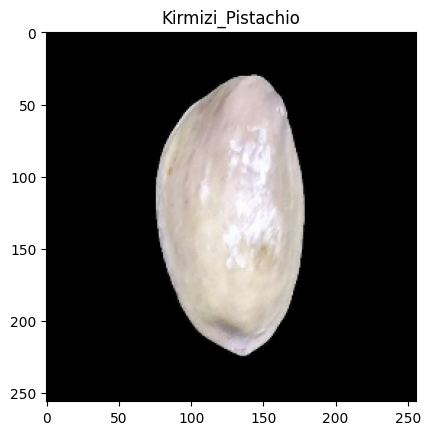

In [25]:
i=int(input("enter batch number."))
for image_batch,label_batch in teds.take(i):# so first batch means 32 images,change each time as shuufling
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print('first image to predict')
    plt.imshow( first_image)
    print("first image's actual label:",classes[first_label])
    batch_prediction=model.predict(image_batch)
    print("predicted label:",batch_prediction[0])# it give 3 probabilites as 3 hai output class
    print("predicted label:",np.argmax(batch_prediction[0]))
    plt.title(classes[np.argmax(batch_prediction[0])])
    
